
# 🌼 제너레이티브AI의 이해 - 1차시(24.11.18)

---


## 1. VAE(Variational Auto Encoder)
- 모델이 숫자 이미지를 압축하고, 복원하는 과정(인코더-디코더)
- 인코더 : 입력 이미지를 잠재공간으로 매핑
- 디코더 : 잠재 공간에서 샘플을 받아 이미지 복원
- 가상환경 실행 후 - pip install opencv-python로 설치!

### Tensorflow를 활용한 celeb데이터셋에 VAE 적용하기

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yunting0123/img-align-celeba")

print("Path to dataset files:", path)

c:\Users\RMARKET\anaconda3\envs\tensor_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\RMARKET\.cache\kagglehub\datasets\yunting0123\img-align-celeba\versions\1


In [4]:
# 데이터 경로 설정
image_dir = "C:/Users/RMARKET/.cache/kagglehub/datasets/yunting0123/img-align-celeba/versions/1/t/celebA"

In [5]:
img_filenames = os.listdir(image_dir)[-1]
img_filenames

'030000.png'

In [6]:
# 1. 이미지 불러오고 전처리 하는 함수 만들기
def load_preprocess_images(image_dir, img_size = (128, 128), num_images = 10000):
    # 경로, 이미지 크기, 최대 로드할 이미지 개수
    images = []
    # 전처리 된 이미지를 추가할 리스트
    img_filenames = os.listdir(image_dir)[:num_images]
    for filename in img_filenames:
        img_path = os.path.join(image_dir, filename)
        # 이미지 파일의 전체 경로를 imgae_dir(폴더 경로) + filename(파일 이름)으로 만들어주기
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0
            # 이미지 정규화
            # [204, 76, 128] = [0.8, 0.3, 0.5] RGB
            images.append(img)
    return np.array(images)

In [7]:
images = load_preprocess_images(image_dir)
images

array([[[[0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         ...,
         [0.78823529, 0.88627451, 0.94901961],
         [0.84705882, 0.92156863, 0.96862745],
         [0.87843137, 0.9372549 , 0.98039216]],

        [[0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         ...,
         [0.79607843, 0.89411765, 0.95294118],
         [0.85098039, 0.92156863, 0.97254902],
         [0.87843137, 0.9372549 , 0.98039216]],

        [[0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         ...,
         [0.81960784, 0.90588235, 0.96078431],
         [0.85490196, 0.9254902 , 0.97647059],
         [0.8745098 , 0.93333333, 0.98431373]],

        ...,

        [[0.23529412, 0.40392157, 0.6745098 ],
         [0.22745098, 0.39215686, 0.6627451 ]

In [8]:
# 2. 샘플링 함수 정의
# 잠재 공간에서 새로운 샘플을 생성하기 위해 데이터 포인트들을 샘플링하는 과정
# 각 데이터포인터들의 평균 값과 로그 분산을 출력하는 함수
def sampling(z_mean, z_log_var):
    # 모델이 새로운 데이터 포인트(z)를 생성할 수 있다
    batch = tf.shape(z_mean)[0] 
    # 딥러닝 프레임워크는 데이터 입력 시 자동으로 배치 크기를 감지
    # 0번째 자리의 값이 배치 사이즈이므로 배치라는 이름의 변수로 저장한 것

    dim = tf.shape(z_mean)[1]
    # 잠재 공간의 차원 값

    epsilon = tf.random.normal(shape = [batch, dim])  
    # 배치 사이즈와 차원의 shape을 갖는 표준정규분포의 무작위 값 생성
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
# tf.exp(0.5 * z_log_var): 로그 분산을 표준편차로 변환하는 과정, 로그 분산에 0.5를 곱해서 지수함수를 적용 -> 표준편차

In [9]:
# 3. 인코더 정의
latent_dim = 200
# 잠재 공간의 차원 - 입력 이미지를 표현 (보통 100에서 200)
# 간단한 데이터나 테스트 목적: 2~10 정도
# 복잡한 이미지나 고차원: 100~200 사용

encoder_input = keras.layers.Input(shape=(128, 128, 3), name='encoder_input')
# 128x128 사이즈의 컬러 이미지를 인풋으로 넣을 것임을 명시적으로 지정한 것 (3: RGB 3차원)
x = keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
# Conv2D: 공간적인 패턴 학습 가능
# 32개의 필터, (3, 3) 커널, 슬라이딩 간격 2, 가장자리에 패딩
x = keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
# x.shape = (batch_size, height, width, channels)
shape_before_flattening = x.shape[1:]
# x를 1차원 벡터로 변환하기 전 정보 저장

# 1차원 벡터로 변환: Conv2D는 이미지의 공간적인 구조를 학습할 수 있으나 결정을 내릴 수는 없다
# 결정을 내릴 수 있는 Dense층을 쌓아주기 위해 1차원 벡터로 변환 (flatten, 평탄화)
x = keras.layers.Flatten()(x)

# 인코더의 마지막 단계
z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)
# 두 레이어는 동일한 입력 x를 받지만, 손실함수와 역전파 과정에 의해 다른 출력을 학습

z = sampling(z_mean, z_log_var)
# 무작위 벡터 값 생성

encoder = keras.models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
# 모델은 세 개의 출력을 반환한다
# z_mean: 인코더가 학습한 잠재공간의 평균 벡터
# z_log_var: 인코더가 학습한 로그 분산 벡터
# z: 평균과 분산을 사용해 샘플링된 잠재 공간의 벡터

In [10]:
# 4. 디코더 정의
decoder_input = keras.layers.Input(shape=(latent_dim, ), name='decoder')
x = keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# Dense 레이어로 잠재공간의 벡터를 디코더 출력에 맞게 변환
# prod: 이 형태의 모든 차원을 곱해 1차원 값으로 변환
# (16, 16, 128) -> 16x16x128
# 먼저 위에서 저장했던 flatten 전 마지막 3차원을 1차원으로 변환 후 Dense 레이어에 적용

x = keras.layers.Reshape(shape_before_flattening)(x)
# 원래 인코더의 마지막 출력 형태인 3차원 텐서로 다시 reshape
x = keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = keras.layers.Conv2D(3, (3, 3), strides=1, activation='sigmoid', padding='same', name='decoder_output')(x)
# 최종 출력이므로 strides를 1로 지정해 넘어가는 값이 없도록 한다
decoder = keras.models.Model(decoder_input, decoder_output, name='decoder')

In [11]:
optimizer = keras.optimizers.Adam()

In [12]:
# 5. 학습 루프 만들기
def train_step(data):
    with tf.GradientTape() as tape:
        # with tf.GradientTape() as tape: tensorflow에서 자동 미분을 위해 설정하는 with 문
        z_mean, z_log_var, z = encoder(data)
        recon = decoder(z)
        # recon: 재구성된 이미지 / 입력 데이터와 비교될 이미지

        # 1. 재구성 손실
        recon_loss = tf.reduce_mean(500 * tf.losses.binary_crossentropy(data, recon))
        # 원본 데이터와 재구성된 이미지 데이터 간의 차이를 픽셀의 이진 분포로 계산
        # 가중치를 500 곱해서 조정 (임의의 값)
        # reduce_mean: 배치 내 모든 데이터 포인트의 평균 손실을 계산한다는 의미

        # 2. KL-발산 손실
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        # axis=1 옵션을 넣었기 때문에 각 차원에 대한 합산

        total_loss = recon_loss + kl_loss
    
    grad = tape.gradient(total_loss, encoder.trainable_weights + decoder.trainable_weights)
    # tape.gradient는 total_loss에 대한 인코더와 디코더의 가중치에 대한 기울기를 계산
    optimizer.apply_gradients(zip(grad, encoder.trainable_weights + decoder.trainable_weights))
    # 계싼된 기울기를 사용하여 Adam 최적화 알고리즘을 통해 인코더와 디코더의 가중치를 업데이트
    return total_loss, recon_loss, kl_loss
    # 총 손실, 재구성 손실, kl-발산 손실을 반환

In [14]:
batch_size = 32
epochs = 10

dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(batch_size)
# 주어진 텐서를 받아 이를 개별 슬라이스로 나눠 데이터 셋을 생성

In [17]:
for epoch in range(epochs):
    print(f'Epoch: {epoch+1} / {epochs}')
    for step, batch_data in enumerate(dataset):
        # 현재 스텝과 배치 데이터를 반환
        total_loss, recon_loss, kl_loss = train_step(batch_data)
        if step % 100 == 0:
            # 스텝이 100의 배수일 때마다
            print(f'step {step}: totla loss = {total_loss.numpy():.4f},'
                  f'recon loss = {recon_loss.numpy():.4f},'
                  f'KL loss = {kl_loss:.4f}')

Epoch: 1 / 10
step 0: totla loss = 347.1665,recon loss = 346.6211,KL loss = 0.5454
step 100: totla loss = 322.4171,recon loss = 317.9273,KL loss = 4.4898
step 200: totla loss = 284.8188,recon loss = 273.4843,KL loss = 11.3345
step 300: totla loss = 289.8303,recon loss = 280.7648,KL loss = 9.0655
Epoch: 2 / 10
step 0: totla loss = 307.0046,recon loss = 296.8404,KL loss = 10.1643
step 100: totla loss = 309.1375,recon loss = 300.5166,KL loss = 8.6209
step 200: totla loss = 299.5285,recon loss = 290.4727,KL loss = 9.0558
step 300: totla loss = 292.5560,recon loss = 280.7899,KL loss = 11.7662
Epoch: 3 / 10
step 0: totla loss = 291.2741,recon loss = 276.6862,KL loss = 14.5879
step 100: totla loss = 303.9640,recon loss = 293.8116,KL loss = 10.1524
step 200: totla loss = 303.2381,recon loss = 291.2737,KL loss = 11.9644
step 300: totla loss = 295.0870,recon loss = 282.7029,KL loss = 12.3841
Epoch: 4 / 10
step 0: totla loss = 301.9473,recon loss = 291.8718,KL loss = 10.0754
step 100: totla loss 

In [20]:
import matplotlib.pyplot as plt

def generate_images(original_images, num_images=5):
    selected = np.random.choice(len(original_images), num_images, replace=False)
    sampled_originals = original_images[selected]

    z_mean, z_log_var, z = encoder.predict(sampled_originals)
    generated_images = decoder.predict(z)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(sampled_originals[i])
        plt.title('original')
        plt.axis('off')
        # 원본 이미지

        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(generated_images[i])
        plt.title('reconstructed')
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 182ms/step


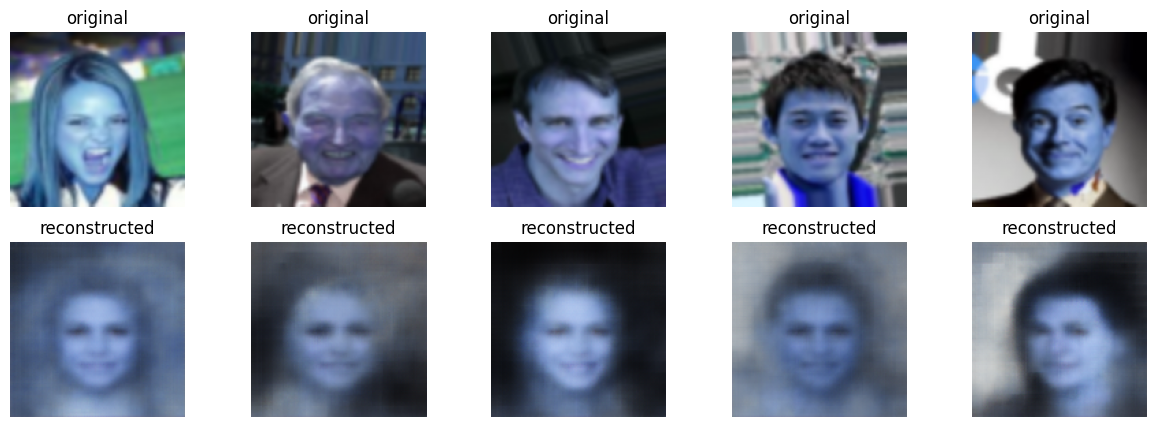

In [21]:
generate_images(images)

In [16]:
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')

In [17]:
load_encoder = keras.models.load_model('vae_encoder.h5', compile=False)
# compile: 기본 값 True > 옵티마이저와 손실함수 추가 설정 가능

---
### Torch를 활용한 MNIST데이터셋에 VAE 적용하기

In [23]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [29]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [30]:
sample_image, sample_label = next(iter(data_loader))

In [31]:
print(f'첫 번째 데이터의 shape: {sample_image.shape}')
# 배치 크기, 채널, 높이, 너비

첫 번째 데이터의 shape: torch.Size([64, 1, 28, 28])


In [33]:
sample_image[0].shape

torch.Size([1, 28, 28])

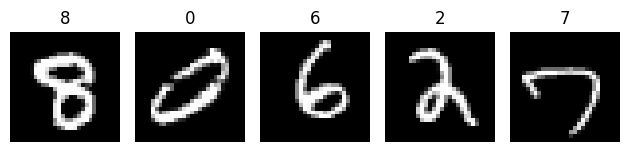

In [32]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_image[i].squeeze(), cmap='gray')
    # squeeze: 차원이 1인 축을 제거하는 메소드 (2차원으로 변경 -> imshow가 기대하는 차원이 2차원이므로)
    plt.title(sample_label[i].item())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
image_size = 28 * 28
# 784: 원래 MNIST 이미지 사이즈 (1차원으로 변환을 위해)
latent_size = 10

W_enc = torch.randn(image_size, latent_size, requires_grad=True)
# (784, 10) / 인코더 가중치
b_enc = torch.zeros(latent_size, requires_grad=True)
# 편향을 0으로 초기화 / 인코더 편향
# 입력이 0이면 -> 출력도 0 / 그것의 균형을 잡아주는게 편향
# 가중치 랜덤, 편향 0으로 설정해줘야 깔끔한 모델로 시작, 편향이 0이어도 문제는 없고 모델 사용중에 업데이트
# 텐서플로는 알아서 편향을 업데이트 해주지만 토치는 편향이 없음.. 직접 설정 필요

In [ ]:
# 인코더 함수
def encoder(x):
    x = x.view(-1, image_size)
    # view: 텐서를 특정 형태로 변환 (-1: 자동으로 해당 차원을 계산)

    z_mean = torch.matmul(x, W_enc) + b_enc
    z_logvar = torch.matmul(x, W_enc) + b_enc
    return z_mean, z_logvar

In [37]:
# 샘플링 함수 정의
def sample(mean, logvar):
    std = torch.exp(0.5*logvar)
    epsilon = torch.randn_like(std)
    # randn_like(x) -> x와 비슷한 형태로 랜덤한 값을 생성
    # 평균이 0이고 표준편차가 1인 정규분포에서 epsilon 샘플링
    return mean + std * epsilon
    # 샘플링된 잠재벡터 계산

In [ ]:
W_dec = torch.randn(latent_size, image_size, requires_grad=True)
# 디코더 가중치 (인코더와 shape 반대로 해야하야 함)
b_dec = torch.zeros(image_size, requires_grad=True)
# 디코더 편향

In [44]:
def decoder(z):
    x_hat = torch.matmul(z, W_dec) + b_dec
    # matmul: 행렬곱을 수행
    return torch.sigmoid(x_hat)
    # 0과 1 사이 값으로 반환해야 하므로 sigmoid

In [40]:
# 손실함수 구성
def loss_function(x, x_hat, mean, logvar):
    recon_loss = ((x.view(-1, image_size) - x_hat.view(-1, image_size))**2).mean()
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [41]:
# 최적화 함수 설정
optimizer = torch.optim.Adam([W_enc, b_enc, W_dec, b_dec], lr=0.001)
# 가중치와 편향을 통해 역전파를 하면서 손실을 줄여나가야 하기 때문에 옵티마이저 함수 안에 값을 넣어줌

In [46]:
epochs = 20
for epoch in range(epochs):
    for images, _ in data_loader:
        mean, logvar = encoder(images)
        z = sample(mean, logvar)
        x_hat = decoder(z)
        loss = loss_function(images, x_hat, mean, logvar)
        # 초기화 + 계산 업데이트 반복
        optimizer.zero_grad()
        # 기울기 초기화
        loss.backward()
        # 역전파를 통해 가중치를 계산
        optimizer.step()
        # 계산된 가중치, 기울기를 업데이트
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
print('학습 완료!')

Epoch 1, Loss: 100786144.0
Epoch 2, Loss: 942454.0625
Epoch 3, Loss: 2949916.5
Epoch 4, Loss: 21051.9375
Epoch 5, Loss: 18442.265625
Epoch 6, Loss: 24467.263671875
Epoch 7, Loss: 33708912.0
Epoch 8, Loss: 320859.5625
Epoch 9, Loss: 21721.888671875
Epoch 10, Loss: 18209.822265625
Epoch 11, Loss: 8494166.0
Epoch 12, Loss: 439985824.0
Epoch 13, Loss: 46983340032.0
Epoch 14, Loss: 24999.005859375
Epoch 15, Loss: 52905.7421875
Epoch 16, Loss: 154313.84375
Epoch 17, Loss: 17656.943359375
Epoch 18, Loss: 19980.111328125
Epoch 19, Loss: 19318352.0
Epoch 20, Loss: 19444.86328125
학습 완료!


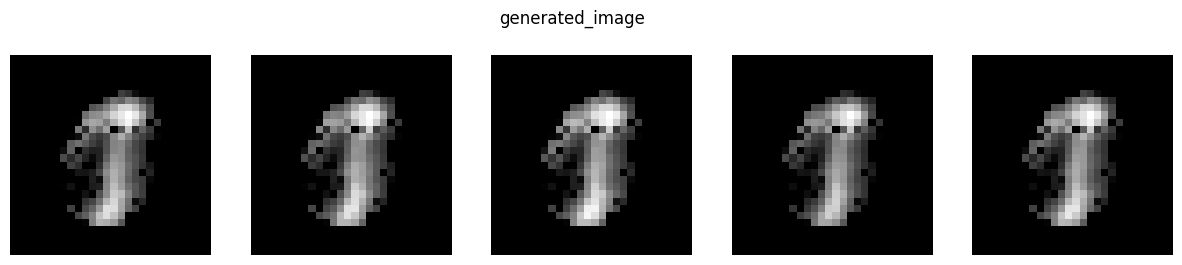

In [51]:
with torch.no_grad():
    count = 5
    z_random = torch.randn(count, latent_size)
    # 잠재 공간에서 무작위로 벡터 샘플링
    generated_image = decoder(z_random).view(count, 28, 28)
    plt.figure(figsize = (15, 3))
    for i in range(count):
        plt.subplot(1, count, i+1)
        plt.imshow(generated_image[i], cmap='gray')
        plt.axis('off')
    plt.suptitle('generated_image')
    plt.show()

## 🌼마무리 문제

다양한 데이터셋을 적용해보세요

Q1. Fashion MNIST
- 28X28 크기의 패션 아이템 이미지로 구성된 흑백 이미지 데이터셋


Q2. CIFAR-10
- 32X32 크기의 색상이 있는 자동차, 동물 등 다양한 객체가 포함된 데이터셋

In [52]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Fashion MNIST 데이터셋 로드 (28x28 크기의 패션 아이템 이미지)
trans = transforms.ToTensor()
fashion_mnist_data = datasets.FashionMNIST(root='./data', train=True, transform=trans, download=True)
data_loader = DataLoader(fashion_mnist_data, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:04<00:00, 6.55MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 121kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.84MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 1.37MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [53]:
simage, slabel = next(iter(data_loader))
print(f'첫 번째 데이터의 shape: {simage.shape}')

첫 번째 데이터의 shape: torch.Size([64, 1, 28, 28])


In [55]:
simage[0], slabel[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

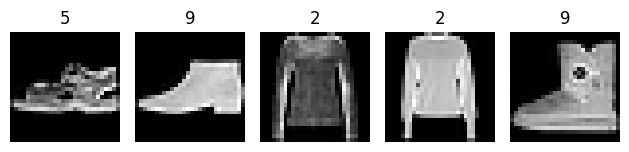

In [56]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(simage[i].squeeze(), cmap='gray')
    plt.title(slabel[i].item())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [57]:
img_size = 28 * 28
lat_size = 20

W_enc = torch.randn(img_size, lat_size, requires_grad=True)
b_enc = torch.zeros(lat_size, requires_grad=True)

In [58]:
def encoder(x):
    x = x.view(-1, img_size)
    z_mean = torch.matmul(x, W_enc) + b_enc
    z_logvar = torch.matmul(x, W_enc) + b_enc
    return z_mean, z_logvar

In [59]:
def sample(mean, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)
    return mean + std * epsilon

In [70]:
W_dec = torch.randn(lat_size, img_size, requires_grad=True)
b_dec = torch.randn(img_size, requires_grad=True)

In [72]:
def decoder(z):
    x_hat = torch.matmul(z, W_dec) + b_dec
    return torch.sigmoid(x_hat)

In [78]:
def loss_function(x, x_hat, mean, logvar):
    recon = ((x.view(-1, img_size) - x_hat.view(-1, img_size))**2).mean()
    kl = -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
    return recon + kl

In [74]:
optimizer = torch.optim.RMSprop([W_enc, b_enc, W_dec, b_enc], lr=0.002)

c:\Users\RMARKET\anaconda3\envs\tensor_env\lib\site-packages\torch\_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


In [79]:
epochs = 30
for epoch in range(epochs):
    for images, _ in data_loader:
        mean, logvar = encoder(images)
        z = sample(mean, logvar)
        x_hat = decoder(z)
        loss = loss_function(images, x_hat, mean, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
print('학습 완료!')

Epoch 1, Loss: 132470976.0
Epoch 2, Loss: 7839070.5
Epoch 3, Loss: 73917.59375
Epoch 4, Loss: 164014128.0
Epoch 5, Loss: 50000.87109375
Epoch 6, Loss: 20281.607421875
Epoch 7, Loss: 15308.384765625
Epoch 8, Loss: 9349.8369140625
Epoch 9, Loss: 10988.49609375
Epoch 10, Loss: 4159.005859375
Epoch 11, Loss: 3864.357177734375
Epoch 12, Loss: 1863.951171875
Epoch 13, Loss: 1385.2999267578125
Epoch 14, Loss: 1533.5062255859375
Epoch 15, Loss: 1264.257568359375
Epoch 16, Loss: 565.7338256835938
Epoch 17, Loss: 482.1287841796875
Epoch 18, Loss: 334.7314758300781
Epoch 19, Loss: 292.6022644042969
Epoch 20, Loss: 258.55438232421875
Epoch 21, Loss: 179.5109100341797
Epoch 22, Loss: 162.3466339111328
Epoch 23, Loss: 149.1868896484375
Epoch 24, Loss: 121.71885681152344
Epoch 25, Loss: 133.35072326660156
Epoch 26, Loss: 98.52014923095703
Epoch 27, Loss: 69.76654815673828
Epoch 28, Loss: 83.9438247680664
Epoch 29, Loss: 105.73841857910156
Epoch 30, Loss: 90.16188049316406
학습 완료!


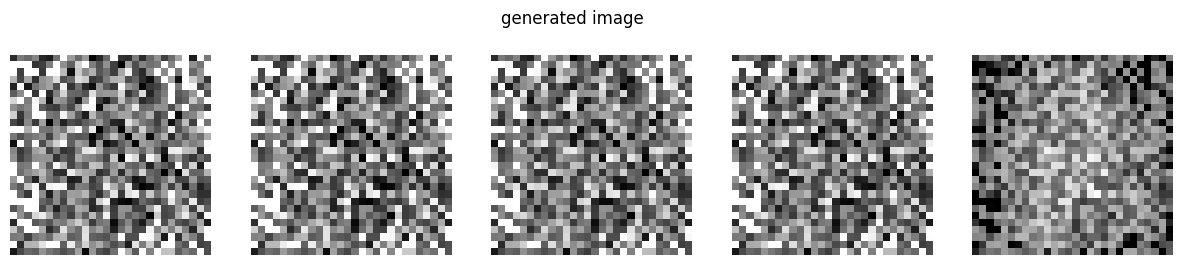

In [81]:
with torch.no_grad():
    count = 5
    z_ran = torch.randn(count, lat_size)
    gen_img = decoder(z_ran).view(count, 28, 28)
    plt.figure(figsize=(15, 3))
    for i in range(count):
        plt.subplot(1, count, i+1)
        plt.imshow(gen_img[i], cmap='gray')
        plt.axis('off')
    plt.suptitle('generated image')
    plt.show()

다른거

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드 (32x32 크기의 컬러 이미지)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 데이터 정규화
])
cifar10_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(cifar10_data, batch_size=64, shuffle=True)
